In [69]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feedparser
from datetime import datetime, timezone
import nltk


In [70]:
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "SPY"]

ticker_queries = {
    "AAPL": "Apple stock",
    "MSFT": "Microsoft stock",
    "NVDA": "NVIDIA stock",
    "AMZN": "Amazon stock",
    "GOOGL": "Google stock",
    "SPY": "SPY ETF"
}


In [71]:
def fetch_google_news_rss(ticker, query, limit=50):
    url = f"https://news.google.com/rss/search?q={query}&hl=en-US&gl=US&ceid=US:en"
    feed = feedparser.parse(url)

    rows = []
    for entry in feed.entries[:limit]:
        title = entry.get("title", "")
        try:
            dt = datetime(*entry.published_parsed[:6], tzinfo=timezone.utc)
        except:
            dt = None

        rows.append({
            "ticker": ticker,
            "headline": title,
            "published_utc": dt
        })

    return pd.DataFrame(rows)



In [72]:
from urllib.parse import quote_plus

def fetch_google_news_rss(ticker, query, limit=50):
    query_encoded = quote_plus(query)

    url = f"https://news.google.com/rss/search?q={query_encoded}&hl=en-US&gl=US&ceid=US:en"

    feed = feedparser.parse(url)

    rows = []
    for entry in feed.entries[:limit]:
        title = entry.get("title", "")
        try:
            dt = datetime(*entry.published_parsed[:6], tzinfo=timezone.utc)
        except:
            dt = None

        rows.append({
            "ticker": ticker,
            "headline": title,
            "published_utc": dt
        })

    return pd.DataFrame(rows)


In [73]:
news_df = pd.concat(
    [fetch_google_news_rss(t, q, limit=50)
     for t, q in ticker_queries.items()],
    ignore_index=True
)

news_df["ticker"] = news_df["ticker"].str.upper().str.strip()
news_df.head()


,ticker,headline,published_utc
0,AAPL,Bank of America delivers sharp take on Apple s...,2026-01-14 13:07:00+00:00
1,AAPL,Can Apple Stock Reach $350 This Year? Here’s W...,2026-01-14 01:03:12+00:00
2,AAPL,Apple Stock: Why The iPhone Giant Could Fall -...,2026-01-14 14:16:16+00:00
3,AAPL,Will AAPL Stock Rally Again in 2026 to Help Ap...,2026-01-12 17:07:00+00:00
4,AAPL,Is Apple Stock a Buy for 2026? - The Motley Fool,2026-01-12 10:00:00+00:00


In [74]:
news_df = pd.concat(
    [fetch_google_news_rss(t, q, limit=50)
     for t, q in ticker_queries.items()],
    ignore_index=True
)

news_df["ticker"] = news_df["ticker"].str.upper().str.strip()
news_df.head()


,ticker,headline,published_utc
0,AAPL,Bank of America delivers sharp take on Apple s...,2026-01-14 13:07:00+00:00
1,AAPL,Can Apple Stock Reach $350 This Year? Here’s W...,2026-01-14 01:03:12+00:00
2,AAPL,Apple Stock: Why The iPhone Giant Could Fall -...,2026-01-14 14:16:16+00:00
3,AAPL,Will AAPL Stock Rally Again in 2026 to Help Ap...,2026-01-12 17:07:00+00:00
4,AAPL,Is Apple Stock a Buy for 2026? - The Motley Fool,2026-01-12 10:00:00+00:00


In [75]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

news_df["sentiment_compound"] = news_df["headline"].astype(str).apply(
    lambda t: sia.polarity_scores(t)["compound"]
)


In [76]:
daily_sent = (
    news_df
    .dropna(subset=["published_utc"])
    .assign(date=lambda x: x["published_utc"].dt.date)
    .groupby(["date", "ticker"])
    .agg(
        sentiment_mean=("sentiment_compound", "mean"),
        headline_count=("sentiment_compound", "count")
    )
    .reset_index()
)

daily_sent["date"] = pd.to_datetime(daily_sent["date"])


In [77]:
news_start = str(daily_sent["date"].min().date())
news_end   = str(daily_sent["date"].max().date())

news_start, news_end


('2025-07-02', '2026-01-15')

In [81]:
df = yf.download(
    ["AAPL","MSFT","NVDA","AMZN","GOOGL","SPY"],
    start=news_start,
    end=news_end,
    group_by="ticker",
    auto_adjust=True,
    progress=False
)

df.head()



Ticker           GOOGL                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2025-07-02  175.268482  178.583354  174.799223  178.363693  29128900   
2025-07-03  178.223914  179.392102  176.776159  179.252319  21689700   
2025-07-07  178.783049  179.022683  175.408272  176.516556  34175600   
2025-07-08  177.574924  177.674760  172.542711  174.090317  40442500   
2025-07-09  174.978941  179.162463  172.502781  176.346817  43025600   

Ticker            AMZN                                                ...  \
Price             Open        High         Low       Close    Volume  ...   
Date                                                                  ...   
2025-07-02  219.729996  221.600006  219.059998  219.919998  30894200  ...   
2025-07-03  221.820007  224.009995  221.360001  223.410004  29632400  ...   
2025-07-07  223.000000  224.289993  222.369995  223.470001  36604100  ...   
2025-07-08  223.919998  224.000000  218.429993  219.360001  45692000  ...   
2025-07-09  221.070007  224.289993  220.470001  222.539993  38155100  ...   

Ticker            AAPL                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2025-07-02  208.471085  212.891771  207.702699  211.993668  67941800   
2025-07-03  211.704266  214.199013  211.364984  213.101334  34955800   
2025-07-07  212.233156  215.775700  208.361318  209.508896  50229000   
2025-07-08  209.658594  210.985786  208.012051  209.568771  42848900   
2025-07-09  209.089778  210.885999  206.784634  210.696396  48749400   

Ticker             SPY                                                
Price             Open        High         Low       Close    Volume  
Date                                                                  
2025-07-02  613.720027  616.951493  613.093615  616.911743  66510400  
2025-07-03  618.900331  622.708507  618.880426  621.773865  51065800  
2025-07-07  619.805029  620.471252  614.346347  617.140320  74814500  
2025-07-08  617.806557  618.562233  615.987037  616.802368  59024600  
2025-07-09  619.218477  621.157308  617.369038  620.501099  66113300  

[5 rows x 30 columns]

In [82]:
print(type(df.columns))
print(df.columns[:20])


<class 'pandas.core.indexes.multi.MultiIndex'>
MultiIndex([('GOOGL',   'Open'),
            ('GOOGL',   'High'),
            ('GOOGL',    'Low'),
            ('GOOGL',  'Close'),
            ('GOOGL', 'Volume'),
            ( 'AMZN',   'Open'),
            ( 'AMZN',   'High'),
            ( 'AMZN',    'Low'),
            ( 'AMZN',  'Close'),
            ( 'AMZN', 'Volume'),
            ( 'NVDA',   'Open'),
            ( 'NVDA',   'High'),
            ( 'NVDA',    'Low'),
            ( 'NVDA',  'Close'),
            ( 'NVDA', 'Volume'),
            ( 'MSFT',   'Open'),
            ( 'MSFT',   'High'),
            ( 'MSFT',    'Low'),
            ( 'MSFT',  'Close'),
            ( 'MSFT', 'Volume')],
           names=['Ticker', 'Price'])


In [88]:
close = df.xs("Close", axis=1, level=1)

# Convert wide → long (panel format)
panel = (
    close
    .stack()
    .reset_index()
    .rename(columns={
        "Date": "date",
        "level_1": "ticker",
        0: "close"
    })
)

panel.head()

,date,Ticker,close
0,2025-07-02,GOOGL,178.363693
1,2025-07-02,AMZN,219.919998
2,2025-07-02,NVDA,157.232376
3,2025-07-02,MSFT,489.368103
4,2025-07-02,AAPL,211.993668


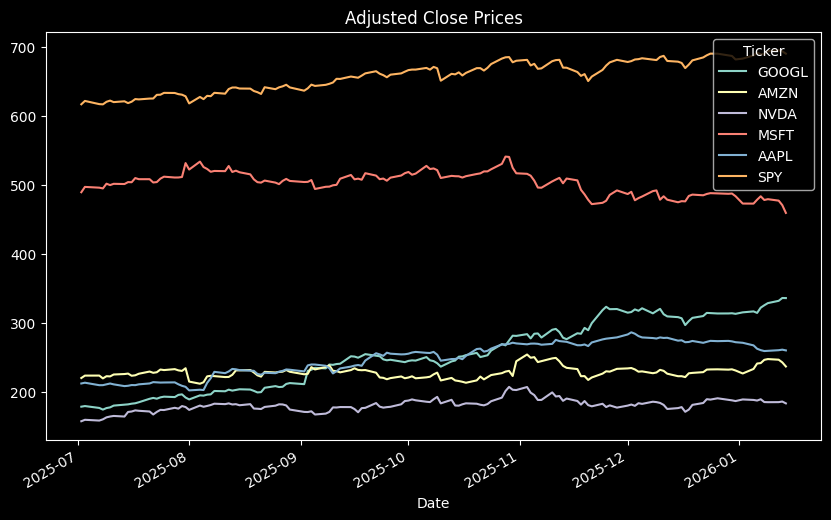

In [89]:
close = df.xs("Close", axis=1, level=1)

close.plot(title="Adjusted Close Prices", figsize=(10,6))
plt.show()


In [90]:
panel.columns

Index(['date', 'Ticker', 'close'], dtype='object')

In [91]:
panel.head()

,date,Ticker,close
0,2025-07-02,GOOGL,178.363693
1,2025-07-02,AMZN,219.919998
2,2025-07-02,NVDA,157.232376
3,2025-07-02,MSFT,489.368103
4,2025-07-02,AAPL,211.993668


In [92]:
# panel columns came from stack/reset_index
panel = panel.copy()

# Normalize date column name
if "Date" in panel.columns:
    panel = panel.rename(columns={"Date": "date"})
elif "date" not in panel.columns:
    # the first column is unnamed date
    panel = panel.rename(columns={panel.columns[0]: "date"})

# Normalize ticker column name
if "Ticker" in panel.columns:
    panel = panel.rename(columns={"Ticker": "ticker"})
elif "level_1" in panel.columns:
    panel = panel.rename(columns={"level_1": "ticker"})
elif "ticker" not in panel.columns:
    # guess the ticker-like column (usually the second column)
    panel = panel.rename(columns={panel.columns[1]: "ticker"})

# Normalize close column name
if "Close" in panel.columns:
    panel = panel.rename(columns={"Close": "close"})
elif 0 in panel.columns:
    panel = panel.rename(columns={0: "close"})
elif "close" not in panel.columns:
    panel = panel.rename(columns={panel.columns[2]: "close"})

panel.columns, panel.head()


(Index(['date', 'ticker', 'close'], dtype='object'),
         date ticker       close
 0 2025-07-02  GOOGL  178.363693
 1 2025-07-02   AMZN  219.919998
 2 2025-07-02   NVDA  157.232376
 3 2025-07-02   MSFT  489.368103
 4 2025-07-02   AAPL  211.993668)

In [93]:
panel = panel.sort_values(["date", "ticker"]).reset_index(drop=True)
panel.head()


,date,ticker,close
0,2025-07-02,AAPL,211.993668
1,2025-07-02,AMZN,219.919998
2,2025-07-02,GOOGL,178.363693
3,2025-07-02,MSFT,489.368103
4,2025-07-02,NVDA,157.232376


In [94]:
panel["return_1d"] = panel.groupby("ticker")["close"].pct_change()
panel["sma_5"] = panel.groupby("ticker")["close"].transform(lambda x: x.rolling(5).mean())
panel["sma_20"] = panel.groupby("ticker")["close"].transform(lambda x: x.rolling(20).mean())
panel["volatility_20"] = panel.groupby("ticker")["return_1d"].transform(lambda x: x.rolling(20).std())

panel["target_up"] = (panel.groupby("ticker")["return_1d"].shift(-1) > 0).astype(int)
panel["target_return"] = panel.groupby("ticker")["return_1d"].shift(-1)

panel = panel.dropna().reset_index(drop=True)
panel.head()


,date,ticker,close,return_1d,sma_5,sma_20,volatility_20,target_up,target_return
0,2025-07-31,AAPL,207.133911,-0.007080,210.720355,210.951862,0.007421,0,-0.025004
1,2025-07-31,AMZN,234.110001,0.017029,231.907999,226.906500,0.010398,0,-0.082696
2,2025-07-31,GOOGL,191.603180,-0.023559,193.687958,185.415773,0.011605,0,-0.014435
3,2025-07-31,MSFT,531.629395,0.039475,515.290900,505.984637,0.010509,0,-0.017601
4,2025-07-31,NVDA,177.850067,-0.007810,176.560214,169.324027,0.014774,0,-0.023332


In [96]:
import numpy as np
import pandas as pd

panel = panel.sort_values(["date","ticker"]).reset_index(drop=True)

features = ["return_1d", "sma_5", "sma_20", "volatility_20"]
X = panel[features]
y_cls = panel["target_up"]
y_reg = panel["target_return"]

# time split: last 20% dates for test
dates = panel["date"].sort_values().unique()
cut = int(len(dates) * 0.8)

train_dates = set(dates[:cut])
test_dates  = set(dates[cut:])

train_mask = panel["date"].isin(train_dates)
test_mask  = panel["date"].isin(test_dates)

X_train, X_test = X[train_mask], X[test_mask]
y_cls_train, y_cls_test = y_cls[train_mask], y_cls[test_mask]
y_reg_train, y_reg_test = y_reg[train_mask], y_reg[test_mask]

X_train.shape, X_test.shape


((552, 4), (138, 4))

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

# Logistic Regression baseline
lr_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

lr_clf.fit(X_train, y_cls_train)
lr_pred = lr_clf.predict(X_test)
lr_proba = lr_clf.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_cls_test, lr_pred))
print("ROC-AUC:", roc_auc_score(y_cls_test, lr_proba))
print("Confusion matrix:\n", confusion_matrix(y_cls_test, lr_pred))
print(classification_report(y_cls_test, lr_pred))

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_cls_train)
rf_pred = rf_clf.predict(X_test)
print("Pred counts:", pd.Series(rf_pred).value_counts())
print("True counts:", pd.Series(y_cls_test).value_counts())

rf_proba = rf_clf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_cls_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_cls_test, rf_proba))
print("Confusion matrix:\n", confusion_matrix(y_cls_test, rf_pred))
print(classification_report(y_cls_test, rf_pred))

# Dumb baseline
always_up = np.ones_like(y_cls_test)
print("\nAlways-up Accuracy:", accuracy_score(y_cls_test, always_up))

print(classification_report(y_cls_test, rf_pred, zero_division=0))



=== Logistic Regression ===
Accuracy: 0.4927536231884058
ROC-AUC: 0.5296218487394958
Confusion matrix:
 [[ 0 70]
 [ 0 68]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.49      1.00      0.66        68

    accuracy                           0.49       138
   macro avg       0.25      0.50      0.33       138
weighted avg       0.24      0.49      0.33       138



C:\Users\Angds\PycharmProjects\stock-price-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Angds\PycharmProjects\stock-price-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Angds\PycharmProjects\stock-price-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Pred counts: 1    132
0      6
Name: count, dtype: int64
True counts: target_up
0    70
1    68
Name: count, dtype: int64

=== Random Forest ===
Accuracy: 0.4927536231884058
ROC-AUC: 0.4634453781512605
Confusion matrix:
 [[ 3 67]
 [ 3 65]]
              precision    recall  f1-score   support

           0       0.50      0.04      0.08        70
           1       0.49      0.96      0.65        68

    accuracy                           0.49       138
   macro avg       0.50      0.50      0.36       138
weighted avg       0.50      0.49      0.36       138


Always-up Accuracy: 0.4927536231884058
              precision    recall  f1-score   support

           0       0.50      0.04      0.08        70
           1       0.49      0.96      0.65        68

    accuracy                           0.49       138
   macro avg       0.50      0.50      0.36       138
weighted avg       0.50      0.49      0.36       138



In [118]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import math

# Ridge baseline
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_reg_train)
ridge_pred = ridge.predict(X_test)

print("=== Ridge Regression ===")
print("MAE:", mean_absolute_error(y_reg_test, ridge_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_reg_test, ridge_pred)))
print("R2:", r2_score(y_reg_test, ridge_pred))

# Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_reg_train)
rf_reg_pred = rf_reg.predict(X_test)

print("\n=== Random Forest Regressor ===")
print("MAE:", mean_absolute_error(y_reg_test, rf_reg_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_reg_test, rf_reg_pred)))
print("R2:", r2_score(y_reg_test, rf_reg_pred))


=== Ridge Regression ===
MAE: 0.00914391348477155
RMSE: 0.012479331978512325
R2: -0.04900089299801569

=== Random Forest Regressor ===
MAE: 0.009126152780978274
RMSE: 0.012667389895998728
R2: -0.0808550548736997


volatility_20    0.284735
sma_5            0.269758
sma_20           0.243536
return_1d        0.201970
dtype: float64


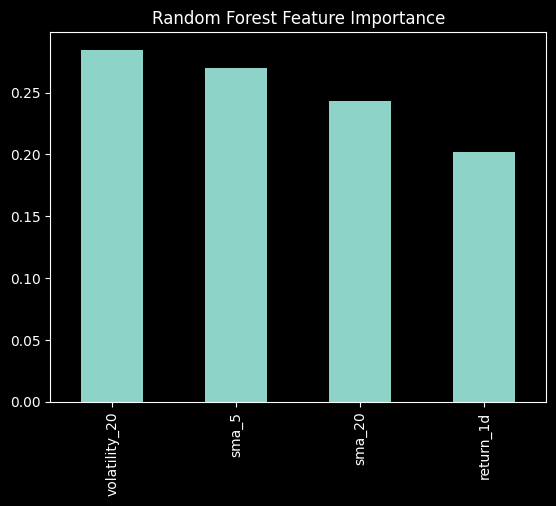

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

fi = pd.Series(rf_clf.feature_importances_, index=features).sort_values(ascending=False)
print(fi)

fi.plot(kind="bar", title="Random Forest Feature Importance")
plt.show()


In [120]:
import nltk
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Angds\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [122]:
from urllib.parse import quote_plus


In [123]:
import pandas as pd
import feedparser
from datetime import datetime, timezone
from urllib.parse import quote_plus

def fetch_google_news_rss(ticker, query, limit=50):
    q = quote_plus(query)  # <-- THIS defines q
    url = f"https://news.google.com/rss/search?q={q}&hl=en-US&gl=US&ceid=US:en"

    feed = feedparser.parse(url)
    rows = []

    for entry in feed.entries[:limit]:
        title = entry.get("title", "")
        try:
            dt = datetime(*entry.published_parsed[:6], tzinfo=timezone.utc)
        except Exception:
            dt = None

        rows.append({
            "ticker": ticker,
            "headline": title,
            "published_utc": dt
        })

    return pd.DataFrame(rows)


In [124]:
ticker_queries = {
    "AAPL": "Apple stock",
    "MSFT": "Microsoft stock",
    "NVDA": "NVIDIA stock",
    "AMZN": "Amazon stock",
    "GOOGL": "Google stock",
    "SPY": "SPY ETF"
}

news_df = pd.concat(
    [fetch_google_news_rss(ticker, query) for ticker, query in ticker_queries.items()],
    ignore_index=True
)

news_df["ticker"].value_counts()


ticker
AAPL     50
MSFT     50
NVDA     50
AMZN     50
GOOGL    50
SPY      50
Name: count, dtype: int64

In [125]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

news_df["sentiment_compound"] = news_df["headline"].astype(str).apply(
    lambda t: sia.polarity_scores(t)["compound"]
)



In [126]:
print("daily_sent columns:", daily_sent.columns.tolist())
print("panel columns (snippet):", [c for c in panel.columns if "sent" in c.lower() or "headline" in c.lower()])


daily_sent columns: ['date', 'ticker', 'sentiment_mean', 'headline_count']
panel columns (snippet): ['sentiment_mean', 'headline_count']


In [127]:
from zoneinfo import ZoneInfo

news_df["published_utc"] = pd.to_datetime(news_df["published_utc"], utc=True, errors="coerce")
news_df = news_df.dropna(subset=["published_utc"]).copy()

news_df["date"] = (
    news_df["published_utc"]
    .dt.tz_convert(ZoneInfo("America/New_York"))
    .dt.normalize()
    .dt.tz_localize(None)
)

daily_sent = (
    news_df
    .groupby(["date", "ticker"])
    .agg(
        sentiment_mean=("sentiment_compound", "mean"),
        headline_count=("headline", "count")
    )
    .reset_index()
)

daily_sent["ticker"].value_counts()


ticker
SPY      30
AAPL     13
AMZN     13
GOOGL    12
MSFT     10
NVDA      6
Name: count, dtype: int64

In [130]:
panel["ticker"] = panel["ticker"].astype(str).str.strip().str.upper()
panel["date"] = pd.to_datetime(panel["date"]).dt.normalize()

daily_sent["ticker"] = daily_sent["ticker"].astype(str).str.strip().str.upper()
daily_sent["date"] = pd.to_datetime(daily_sent["date"]).dt.normalize()

panel = panel.merge(daily_sent, on=["date", "ticker"], how="left")

print([c for c in panel.columns if "sent" in c.lower() or "headline" in c.lower()])


['sentiment_mean_x', 'headline_count_x', 'sentiment_mean_y', 'headline_count_y', 'sentiment_mean', 'headline_count']


In [131]:
panel["sentiment_mean"] = panel["sentiment_mean"].fillna(0)
panel["headline_count"] = panel["headline_count"].fillna(0)


In [132]:
# 1) check dtypes
print("panel dtypes:\n", panel[["date", "ticker"]].dtypes)
print("daily_sent dtypes:\n", daily_sent[["date", "ticker"]].dtypes)

# 2) check ranges
print("\npanel date range:", panel["date"].min(), "->", panel["date"].max())
print("daily_sent date range:", daily_sent["date"].min(), "->", daily_sent["date"].max())

# 3) check tickers
print("\npanel tickers:", sorted(panel["ticker"].astype(str).unique()))
print("daily_sent tickers:", sorted(daily_sent["ticker"].astype(str).unique()))

# 4) how many keys match BEFORE filling NaNs?
inner_keys = panel[["date","ticker"]].merge(daily_sent[["date","ticker"]], on=["date","ticker"], how="inner")
print("\nmatching (date,ticker) pairs:", len(inner_keys))


panel dtypes:
 date      datetime64[ns]
ticker            object
dtype: object
daily_sent dtypes:
 date      datetime64[ns]
ticker            object
dtype: object

panel date range: 2025-07-31 00:00:00 -> 2026-01-13 00:00:00
daily_sent date range: 2025-10-09 00:00:00 -> 2026-01-14 00:00:00

panel tickers: ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA', 'SPY']
daily_sent tickers: ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA', 'SPY']

matching (date,ticker) pairs: 63


In [133]:
ticker_queries = {
    "AAPL": "Apple stock",
    "MSFT": "Microsoft stock",
    "NVDA": "NVIDIA stock",
    "AMZN": "Amazon stock",
    "GOOGL": "Google stock",
    "SPY": "SPY ETF"
}

news_df = pd.concat(
    [fetch_google_news_rss(ticker, query, limit=50)
     for ticker, query in ticker_queries.items()],
    ignore_index=True
)

# normalize ticker formatting
news_df["ticker"] = news_df["ticker"].astype(str).str.strip().str.upper()

news_df["ticker"].value_counts()



ticker
AAPL     50
MSFT     50
NVDA     50
AMZN     50
GOOGL    50
SPY      50
Name: count, dtype: int64

<Axes: title={'center': 'Total Headlines Per Day (All Tickers)'}, xlabel='date'>

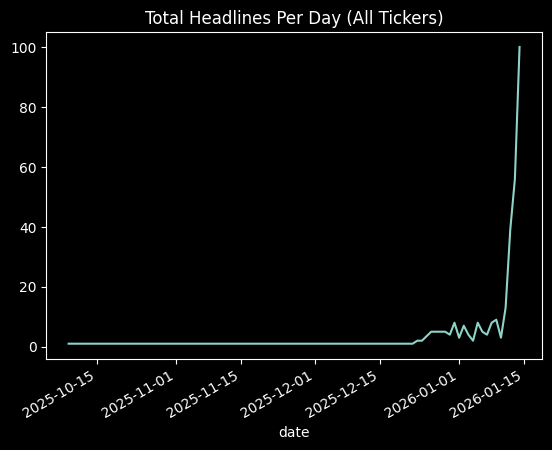

In [134]:
cov = daily_sent.groupby("date")["headline_count"].sum()
cov.plot(title="Total Headlines Per Day (All Tickers)")


<Axes: title={'center': 'Total Headlines by Ticker'}, xlabel='ticker'>

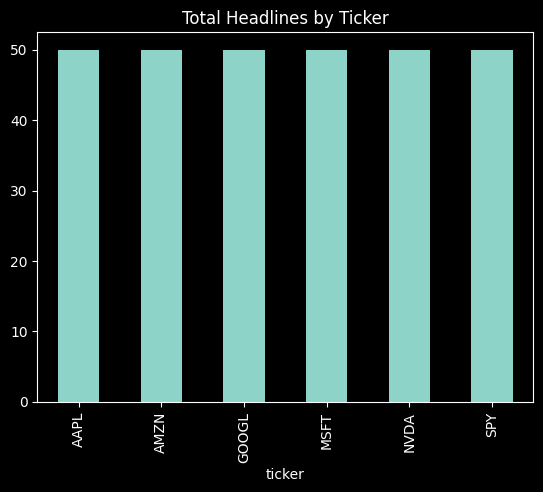

In [135]:
daily_sent.groupby("ticker")["headline_count"].sum().sort_values().plot(kind="bar", title="Total Headlines by Ticker")


<Axes: title={'center': 'Sentiment Mean vs Next-Day Return (Days With News)'}, xlabel='sentiment_mean', ylabel='target_return'>

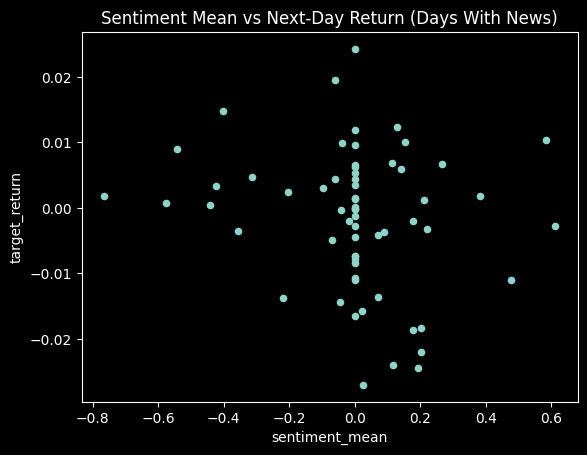

In [136]:
tmp = panel[panel["headline_count"] > 0].copy()
tmp.plot.scatter(x="sentiment_mean", y="target_return", title="Sentiment Mean vs Next-Day Return (Days With News)")


In [137]:
features_tech = ["return_1d", "sma_5", "sma_20", "volatility_20"]
features_tech_nlp = features_tech + ["sentiment_mean", "headline_count"]

X_tech = panel[features_tech]
X_nlp  = panel[features_tech_nlp]

y_cls = panel["target_up"]
y_reg = panel["target_return"]


In [138]:
# --- Time-based split (last 20% of dates as test) ---
panel = panel.sort_values(["date", "ticker"]).reset_index(drop=True)

dates = panel["date"].sort_values().unique()
cut = int(len(dates) * 0.8)

train_dates = set(dates[:cut])
test_dates  = set(dates[cut:])

train_mask = panel["date"].isin(train_dates)
test_mask  = panel["date"].isin(test_dates)

# Split tech-only
Xtech_train, Xtech_test = X_tech[train_mask], X_tech[test_mask]
# Split tech+nlp
Xnlp_train, Xnlp_test   = X_nlp[train_mask],  X_nlp[test_mask]

ycls_train, ycls_test = y_cls[train_mask], y_cls[test_mask]
yreg_train, yreg_test = y_reg[train_mask], y_reg[test_mask]

Xtech_train.shape, Xtech_test.shape, Xnlp_train.shape, Xnlp_test.shape


((552, 4), (138, 4), (552, 6), (138, 6))

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

def eval_classifier(Xtr, Xte, ytr, yte, name="model"):
    clf = RandomForestClassifier(
        n_estimators=400,
        max_depth=8,
        min_samples_leaf=50,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    )
    clf.fit(Xtr, ytr)
    pred = clf.predict(Xte)
    proba = clf.predict_proba(Xte)[:, 1]

    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(yte, pred))
    print("ROC-AUC:", roc_auc_score(yte, proba))
    print("Confusion matrix:\n", confusion_matrix(yte, pred))
    print(classification_report(yte, pred, zero_division=0))
    return clf

clf_tech = eval_classifier(Xtech_train, Xtech_test, ycls_train, ycls_test, name="RF (Tech only)")
clf_nlp  = eval_classifier(Xnlp_train,  Xnlp_test,  ycls_train, ycls_test, name="RF (Tech + NLP)")



=== RF (Tech only) ===
Accuracy: 0.47101449275362317
ROC-AUC: 0.4661764705882353
Confusion matrix:
 [[22 48]
 [25 43]]
              precision    recall  f1-score   support

           0       0.47      0.31      0.38        70
           1       0.47      0.63      0.54        68

    accuracy                           0.47       138
   macro avg       0.47      0.47      0.46       138
weighted avg       0.47      0.47      0.46       138


=== RF (Tech + NLP) ===
Accuracy: 0.4782608695652174
ROC-AUC: 0.4608193277310924
Confusion matrix:
 [[24 46]
 [26 42]]
              precision    recall  f1-score   support

           0       0.48      0.34      0.40        70
           1       0.48      0.62      0.54        68

    accuracy                           0.48       138
   macro avg       0.48      0.48      0.47       138
weighted avg       0.48      0.48      0.47       138



In [140]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def eval_regressor(Xtr, Xte, ytr, yte, name="model"):
    reg = RandomForestRegressor(
        n_estimators=400,
        max_depth=12,
        min_samples_leaf=50,
        random_state=42,
        n_jobs=-1
    )
    reg.fit(Xtr, ytr)
    pred = reg.predict(Xte)

    rmse = np.sqrt(mean_squared_error(yte, pred))
    mae = mean_absolute_error(yte, pred)

    print(f"\n=== {name} ===")
    print("RMSE:", rmse)
    print("MAE:", mae)
    return reg, pred

reg_tech, pred_tech = eval_regressor(Xtech_train, Xtech_test, yreg_train, yreg_test, "RF Reg (Tech only)")
reg_nlp,  pred_nlp  = eval_regressor(Xnlp_train,  Xnlp_test,  yreg_train, yreg_test, "RF Reg (Tech + NLP)")



=== RF Reg (Tech only) ===
RMSE: 0.012667389895998728
MAE: 0.009126152780978274

=== RF Reg (Tech + NLP) ===
RMSE: 0.012667389895998728
MAE: 0.009126152780978274


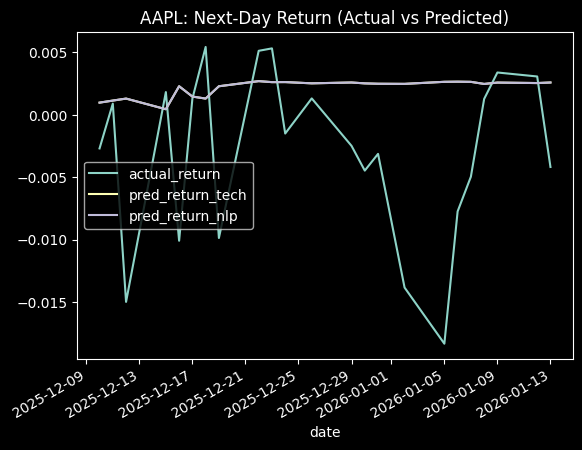

In [145]:
import matplotlib.pyplot as plt
import pandas as pd

plot_df = pd.DataFrame({
    "date": panel.loc[test_mask, "date"].values,
    "ticker": panel.loc[test_mask, "ticker"].values,
    "actual_return": yreg_test.values,
    "pred_return_tech": pred_tech,
    "pred_return_nlp": pred_nlp
}).sort_values(["date", "ticker"])

# Plot one ticker so it’s readable
t = "AAPL"
tmp = plot_df[plot_df["ticker"] == t].set_index("date")

tmp[["actual_return", "pred_return_tech", "pred_return_nlp"]].plot(title=f"{t}: Next-Day Return (Actual vs Predicted)")



plt.show()


In [146]:
from sklearn.metrics import mean_squared_error
import numpy as np

print("Tech RMSE:", np.sqrt(mean_squared_error(y_reg_test, pred_tech)))
print("NLP RMSE:", np.sqrt(mean_squared_error(y_reg_test, pred_nlp)))


Tech RMSE: 0.012667389895998728
NLP RMSE: 0.012667389895998728
